In [3]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [8]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=5, image_size=224):
        self.ids = ids
        self.path = path
       
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, idx_name,idy_name):
        ## Path
        image_path = os.path.join(self.path, "/New folder/ph2_resized2/trainx", idx_name) 
        mask_path = os.path.join(self.path, "/New folder/ph2_resized2/trainy",idy_name)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        
        mask = cv2.imread(mask_path, -1)
        
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name,"Y_"+id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        mask= np.expand_dims(mask, axis=-1)
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [9]:
image_size = 224
train_path = "E:/New folder/ph2_resized2"
epochs = 20
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path+"/trainx"))[2]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

[]
(0,) (0, 1)


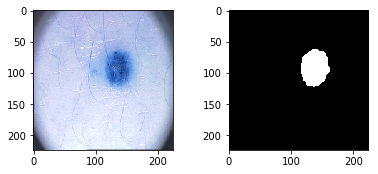

In [59]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [60]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


In [61]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [90]:
from swa.keras import SWA
start_epoch = 15

# define swa callback
swa = SWA(start_epoch=start_epoch, 
          lr_schedule='constant',
          batch_size=8,
          verbose=1)

In [88]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
model = UNet()
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer= 'sgd', loss="binary_crossentropy", metrics=["acc"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_247 (Conv2D)             (None, 224, 224, 16) 448         input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_248 (Conv2D)             (None, 224, 224, 16) 2320        conv2d_247[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_52 (MaxPooling2D) (None, 112, 112, 16) 0           conv2d_248[0][0]                 
__________________________________________________________________________________________________
conv2d_249

In [91]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
session = keras.backend.get_session()
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, callbacks=[swa])
    

Epoch 1/20
23/23 [==============================] - 211s 9s/step - loss: 4.6235 - acc: 0.6238 - val_loss: 4.3675 - val_acc: 0.8114
Epoch 2/20
23/23 [==============================] - 109s 5s/step - loss: 3.5544 - acc: 0.6431 - val_loss: 0.7227 - val_acc: 0.8049
Epoch 3/20
23/23 [==============================] - 90s 4s/step - loss: 3.6120 - acc: 0.6090 - val_loss: 1.4036 - val_acc: 0.1941
Epoch 4/20
23/23 [==============================] - 84s 4s/step - loss: 4.0801 - acc: 0.6004 - val_loss: 1.2571 - val_acc: 0.8059
Epoch 5/20
23/23 [==============================] - 84s 4s/step - loss: 3.9166 - acc: 0.6480 - val_loss: 1.1184 - val_acc: 0.8059
Epoch 6/20
23/23 [==============================] - 97s 4s/step - loss: 3.7609 - acc: 0.6560 - val_loss: 1.0282 - val_acc: 0.8059
Epoch 7/20
23/23 [==============================] - 102s 4s/step - loss: 3.5081 - acc: 0.6646 - val_loss: 0.8461 - val_acc: 0.8059
Epoch 8/20
23/23 [==============================] - 91s 4s/step - loss: 3.5843 - acc: 0

In [92]:
pred=model.predict(x)


In [97]:
cv2.imshow("prediction", (pred[1]*255).astype(np.uint8))
cv2.imshow("X",(x[1]*255).astype(np.uint8))
cv2.imshow("Y",(y[1]*255).astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()